# The Mandelbrottle

This is a shameless ripoff of an idea of Gabriel and Bernat 
at the [ICERM](https://icerm.brown.edu/programs/sp-f19/)
Illustrating Math program.

They worked out how to use [chimera](https://www.cgl.ucsf.edu/chimera/)
to get an STL file from a multi image TIFF by stacking layers of voxels.
Below we build a TIFF for importing in Chimera.

Each level set is a Julia set with the corresponding $c$
in $f_c(z) = z^2 + c$ on a circle passing through 0.

---


## Technical notes

1. If you have downloaded this notebook then you already have Anaconda
and you shouldn't need to install anything except maybe svgpathtools

1. A priori this file is enough to make an STL to print the bottle.
Well actually Chimera makes the STL we make a multi image TIFF
to load in Chimera.
If you don't have the *json* for the profile
you can copy paste the SVG path into a cell
and create a variable from it.

1. Theoretically we can use Chimera directly from a notebook
with [this package](https://pypi.org/project/pychimera/0.1.11/)
but it only works with python 2.7 and I'm tired of building environments.

---

## Here is the bottle top 

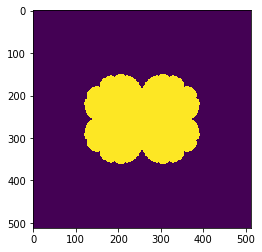

In [69]:
plt.imshow(julia(.25))

## Here is what the mesh looks like in Chimera

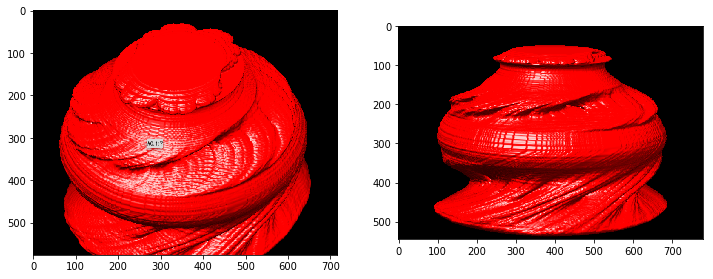

In [77]:
pic1 = imageio.imread('./coke_chimera1.png')
pic2 = imageio.imread('./coke_chimera2.png')

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,12))
ax1.imshow(pic1)
ax2.imshow(pic2)

In [73]:
!pwd

/home/gregmcshane/COKE


## So let's get started

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import imageio 

# I might run this in notebook and not lab so
%matplotlib inline
# skimage is sensitive about letting u import so....
from skimage.transform import resize, rotate
from svgpathtools import  parse_path

def mk_gif(frames, fn='weather.gif', duration=.3):
    with imageio.get_writer(fn, mode='I',duration=duration) as writer:
        for frame in frames:
            if frame is None: continue
            writer.append_data(frame)
            

# Building the profile and a path in the Mandelbrot set

I gave up hand coding the profile with nested **if** statements and 

- wrote an extension  for **Inkscape** to export the SVG path in json
- which is parsed  to an object with a parameterised 2D path
- which I can interpolate to get level sets

There was probably an extension already to do this but 
coding it took less time than looking and configuring.

In [11]:
import json, os
fn = os.environ['HOME'] + '/coke7.json'
with open(fn,'r') as fp:
    data = json.load(fp)
    
pth = data['svg']
pth = pth.replace(',', ' ')
bez = parse_path(pth)

The path doesn't have many nodes so 
I view it in case I accidentally overwrite the .json.

In [12]:
data['svg']

'm 85.414412,239.54468 c 0,0 -2.816565,-5.00727 -2.615772,-8.57546 -0.02264,-8.46582 4.862962,-17.60679 5.384642,-24.72846 0.565625,-8.45022 -6.624797,-34.68114 -3.421545,-38.97664 -0.997699,-8.34589 1.076481,-23.75128 0.867481,-31.72875 -0.432564,-10.57738 5.1889,-17.62001 10.490401,-37.21014 1.020208,-4.506484 2.236318,-9.527354 1.653163,-14.110928 -0.146696,-1.153022 0,0 -1.653161,-3.070159 0.255133,-1.418975 -0.0493,-5.199277 1.536918,-6.584557 2.212619,-1.932324 2.958291,-2.697352 2.958291,-2.697352'

# Setting the parameters

A coke bottle consists of 4 pieces:

- the base
- the middle bulge where the label goes
- the neck
- the top

So here are the values I set from the profile

```
start_middle = .44
end_middle = .64
start_neck = .83
end_neck =.94
```

You should tweak them in the cell below

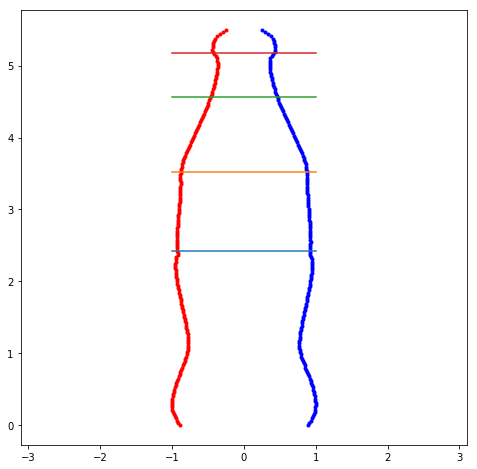

In [59]:
#this is global 
num_layers = 180

T = np.linspace(0,1,num_layers)
myPath = [bez.point(t) for t in T]

#the path pts have to be in ascending order for np.interp()
X, Y = list(zip(* [(z.real,-z.imag) for z in reversed(myPath)] ))
X, Y = list(zip(* [(z.real,-z.imag) for z in myPath] ))
X, Y = np.array(X), np.array(Y)

# ff stands for fudge factor
ff = abs((max(Y) - min(Y)) /(max(X) - min(X)))

Y = (Y - min(Y))
Y =  Y/max(Y)
X =   1.2*(X - min(X) )/(max(X) - min(X)) 
X  -=  1.6

X /= min(X)
            
R = np.interp(T,Y,X) 

#center the design manually
#cc = .25
#R = (1-cc)*R + cc


# comment the next line out to see the design as is
ff = 5.5
plt.figure(figsize=(8, 8))
plt.axis('equal')
plt.plot([-r for r in R], ff*T, 'r.')
plt.plot(R, ff*T, 'b.')

#there are 2 flat parts on a bottle
#the middle where the label goes and the neck
start_middle = .44
end_middle = .64
start_neck = .83
end_neck =.94

for hh in [start_middle, end_middle, start_neck, end_neck]:
    xx,yy = [-1,1], [ff*hh,ff*hh]
    plt.plot(xx,yy)




# Let's improve the Julia sets we use

but first let's generate a Mandelbrot set 
as a reference for when we display the path.

---

## Technical comment

I use numpy arrays and boolean masks.
It's not much slower than cython 
and there are less LOC.

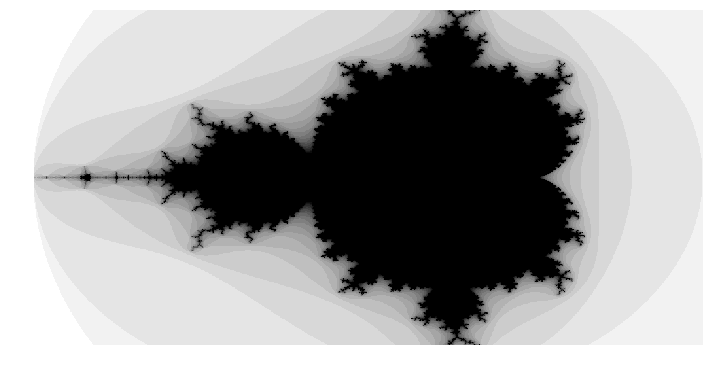

In [8]:
npts = 512
max_iter = 20

X = np.linspace(-2, 1, 2*npts)
Y = np.linspace(-1, 1, npts)

#broadcast the xs to a square array
C = X[:, None] + 1J*Y
#initial value is always zero
Z = np.zeros_like(C)

exit_times = max_iter * np.ones(C.shape, np.int8)
mask = exit_times > 0

for k in range(max_iter):
    Z[mask] = Z[mask] * Z[mask] + C[mask]
    mask, old_mask = abs(Z) < 2, mask
    #use XOR to detect the area which has changed 
    exit_times[mask ^ old_mask] = k
    
#r,g,b layers are all the same
image = np.stack((exit_times,)*3).T
#choose a coloring scheme now
image = 1 - image/max_iter

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.axis('off')
ax.set_aspect(1) 
u = ax.imshow(image)

# And now the path we use

it's actually just going round a circle twice

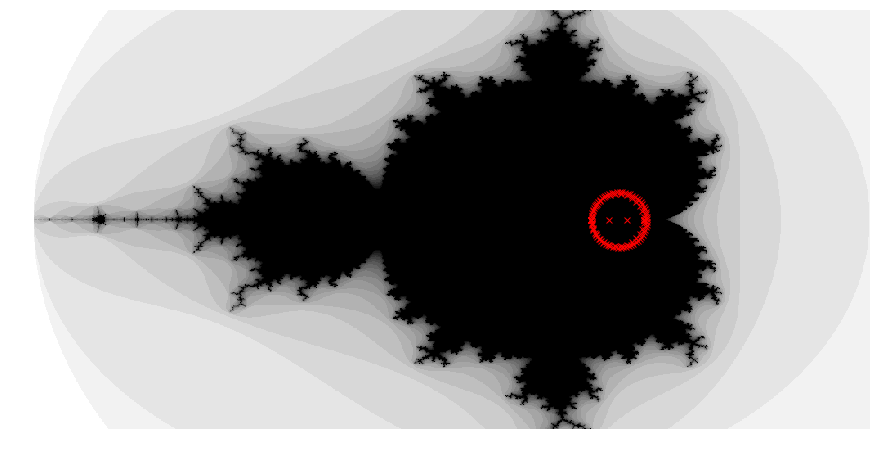

In [55]:
def z2pt(z,im):
    '''generic helper'''
    sy,sx,l = im.shape
    x =  z.real*sx/4 + sx/3*2
    y =  -z.imag*sy/2 + sy/2
    return x,y


def cardoid(z):
    return .5*z*(1-.5*z)

cardoid = np.vectorize(cardoid)


def path_in_mandelbrot(t):
    diam1, diam2 = .265, .25
    if t < start_middle:
        tt = np.interp(t,[ 0,start_middle], 
                          [0, 2*np.pi*1J])
        #first circle goes further out
        return .5*.diam1*(1 - np.exp(tt) )
    
    #flat part in the middle for the label
    if t < end_middle:
        return 0
    #second spiral
    if t < start_neck:
        tt = np.interp(t, [end_middle, start_neck],
                           [0, 2*np.pi*1J])
        
        return .5*.diam2*(1 - np.exp(tt) )
    
    #flat part near the neck
    if t < end_neck:
        return 0
    
    #make a cap
    if t <.98: return .25
    #interpolate to circle
    return np.interp(t,[0.98,1],
                       [0.25,0])

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
ax.axis('off')
ax.set_aspect(1) 

plt.imshow(image)
U,V = list(zip(* [z2pt(path_in_mandelbrot(t),image ) for t in T[:]]))
ax.plot(U,V,'rx')

z = cardoid( [np.exp(2*np.pi*1J/4) ])


# Modded code

we need the Julia set code as a function to run on the path in the Mandelbrot set
that we have chosen in the Mandelbrojt set. 

Let's check that we have the right number of layers first.

In [60]:
num_layers

180

In [61]:
def julia(c=.25 + .1J,
    npts=512,
    max_iter=20):

    X = np.linspace(-2, 2, npts)
    Y = np.linspace(-2, 2, npts)
    Z = X[:, None] + 1J*Y
    
    #255 is important here 
    #to avoid blank images on rescaling
    exit_times =  255 - np.zeros(Z.shape, np.uint8)
    mask = exit_times > 0

    for k in range(max_iter):
        Z[mask] = Z[mask] * Z[mask] + c
        mask = abs(Z) < 2
        exit_times[ np.logical_not(mask)] = 0
    
    return exit_times
    
frames = [julia(path_in_mandelbrot(t)) for t in T ]

Test to see it really works:

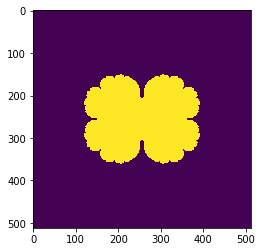

In [57]:
plt.imshow(frames[0])
plt.imshow(julia(.265))

# Now we need to do  some post processing

This will consists of resizing and a tiny amount of rotation to get texture.

---

## Technical comment
Remember to make sure there is enough contrast in the image
or else u will get a blank.
This is an  issue  here because I'm working with
integer values and normally it is implicit 
that these operations use interpolation.

We'll set up a function to do this:

In [21]:
def rebox(im,
          ss=.5,
          rr=10):

    '''change size and rotate a square image
    insert in the middle of a black image 
    of the same size as original'''
    
    sx, sy = im.shape
    
    #so I want to stay in uint8 so I preserve range
    layer = resize(im, (int(sx*ss), int(sy*ss)),  preserve_range=True)
    layer = rotate(layer, rr, preserve_range=True)
    
    dx, dy = layer.shape
    cx = sx//2 -  dx//2
    
    blk = np.zeros_like(im)
    #glue it in there baby
    blk[cx:cx + dx, cx:cx + dx] = layer[:]  
    im = np.stack((blk,)*3).T
    return im
          

# Output

so we do a pass over the images
- resizing  and rotating
- saving to a multi image TIFF


In [62]:
def angle(t, num_layers):
    s = t/num_layers
    #stop rotating
    if (start_middle  < s < end_middle) or start_neck < s :
        return 0
    else:
        return t

In [63]:
ims = [ rebox( im, r, angle(t, len(frames))) 
          for im, r, t in zip( frames, R, range(1000))]

# Warning

### fecking Chimera doesn't detect the number of pages/slices so you should set it fom this

In [56]:
len(ims)

180

### to get a rough idea of what's going on

In [64]:
imageio.mimwrite('pp.gif',ims)

### and output for chimera to process


In [65]:
imageio.mimwrite('coke.tiff', ims,format='TIFF')

In [58]:
round(92)

92